# **13E054VI Veštačka inteligencija**

**Drugi domaći zadatak**  
student: Aleksandra Ljubenović 2020/0117

# Zadatak 1

<u>Metod eliminacije</u>

<img src="VI_dz2_z1a_1.jpeg" style="width: 50%;">
<img src="VI_dz2_z1a_2.jpeg" style="width: 50%;">

<u>Uzorkovanje sa odbacivanjem</u>

p(c+|f+,g+) ~ (# p(\*,\*,c+,\*,f+,g+)) / (# p(\*,\*,\*,\*,f+,g+)) 

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random

N = 50000     # veličina uzorka
Nr = 100    # broj ponavljanja procedure

# Tabele (uslovnih) verovatnoća

p_a = np.array([0.6, 0.4])                                    # (a)
p_b = np.array([[0.7,0.3],[0.2,0.8]])                         # (a,b)                 
p_c = np.array([[0.7,0.3],[0.3,0.7]])                         # (a,c)
p_e = np.array([[[0.1,0.9],[0.5,0.5]],[[0.2,0.8],[0.8,0.2]]]) # (b,c,e)
p_f = np.array([[0.4,0.6],[0.6,0.4]])                         # (e,f)
p_g = np.array([[0.8,0.2],[0.3,0.7]])                         # (e,g)

# Estimacija uslovne verovatnoće p(c+|f+,g+)

p_arr_1 = np.zeros((Nr))

for i in range(Nr):

    S = 0
    n_samples = 0
    
    while(n_samples < N):
        
        # Uzorkovanje promenljivih
        # a
        a = 0 if random.random() <= p_a[0] else 1
        # b
        b = 0 if random.random() <= p_b[a,0] else 1
        # c
        c = 0 if random.random() <= p_c[a,0] else 1
        # e
        e = 0 if random.random() <= p_e[b,c,0] else 1
        # f
        if random.random() <= p_f[e,0]:   # odbacivanje! (f = f-)
            continue
        else:   # f = f+
            # g
            if random.random() <= p_g[e,0]:   # odbacivanje! (g = g-)
                continue
            else:   # g = g+
                n_samples += 1

                if c == 1:  # c = c+
                    S += 1        
    
    # Estimacija tražene verovatnoće za jedan uzorak
    p_est = S/N
    p_arr_1[i] = p_est

p_mean_1 = np.mean(p_arr_1)
p_std_1 = np.std(p_arr_1)


<u>Gibsovo uzorkovanje</u>

In [14]:
p_arr_2 = np.zeros((Nr))

for i in range(Nr):

    # Inicijalizacija promenljivih
    (a,b,c,e) = tuple([int(random.random()//0.5) for _ in range(4)])    # nasumična inicijalizacija
    f = 1
    g = 1

    # Generisanje uzorka
    S = 0
    for _ in range(N):
        
        # A ~ p(A|MP(A)) ~ p(B|A)p(C|A)p(A)
        tmp = random.random()
        p_tmp = p_b[0,b]*p_c[0,c]*p_a[0] / (p_b[0,b]*p_c[0,c]*p_a[0] + p_b[1,b]*p_c[1,c]*p_a[1])
        a = 0 if tmp <= p_tmp else 1

        # B ~ p(B|MP(B)) ~ p(E|B,C)p(B|A)
        tmp = random.random()
        p_tmp = p_e[0,c,e]*p_b[a,0] / (p_e[0,c,e]*p_b[a,0] + p_e[1,c,e]*p_b[a,1])
        b = 0 if tmp <= p_tmp else 1

        # C ~ p(C|MP(C)) ~ p(E|B,C)p(C|A)
        tmp = random.random()
        p_tmp = p_e[b,0,e]*p_c[a,0] / (p_e[b,0,e]*p_c[a,0] + p_e[b,1,e]*p_c[a,1])
        if tmp <= p_tmp:
            c = 0
        else:
            c = 1
            S += 1

        # E ~ p(E|MP(E)) ~ p(f+|E)p(g+|E)p(E|B,C)
        tmp = random.random()
        p_tmp = p_f[0,f]*p_g[0,g]*p_e[b,c,0] / (p_f[0,f]*p_g[0,g]*p_e[b,c,0] + p_f[1,f]*p_g[1,g]*p_e[b,c,1])
        e = 0 if tmp <= p_tmp else 1

    # Estimacija tražene verovatnoće za jedan uzorak
    p_est = S/N
    p_arr_2[i] = p_est

        
p_mean_2 = np.mean(p_arr_2)
p_std_2 = np.std(p_arr_2)


<u>Prikaz rezultata</u>



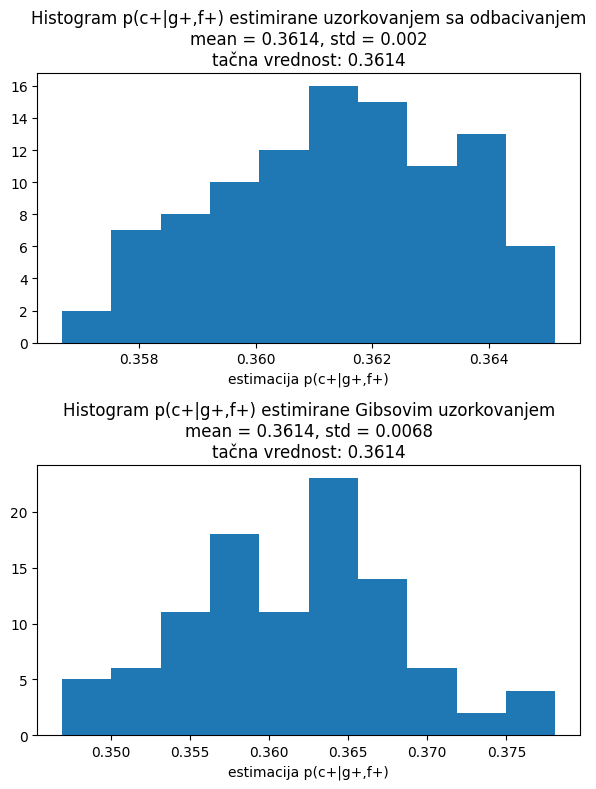

In [77]:
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
plt.hist(p_arr_1,bins = round(np.sqrt(Nr)))
plt.xlabel("estimacija p(c+|g+,f+)")
plt.title("Histogram p(c+|g+,f+) estimirane uzorkovanjem sa odbacivanjem\n"
            "mean = {}, std = {}\n"
                "tačna vrednost: 0.3614".format(round(p_mean_1,4),round(p_std_1,4)));
plt.subplot(2,1,2)
plt.hist(p_arr_2,bins = round(np.sqrt(Nr)))
plt.xlabel("estimacija p(c+|g+,f+)")
plt.title("Histogram p(c+|g+,f+) estimirane Gibsovim uzorkovanjem\n"
            "mean = {}, std = {}\n"
                "tačna vrednost: 0.3614".format(round(p_mean_2,4),round(p_std_2,4)));
plt.tight_layout()

# Zadatak 2



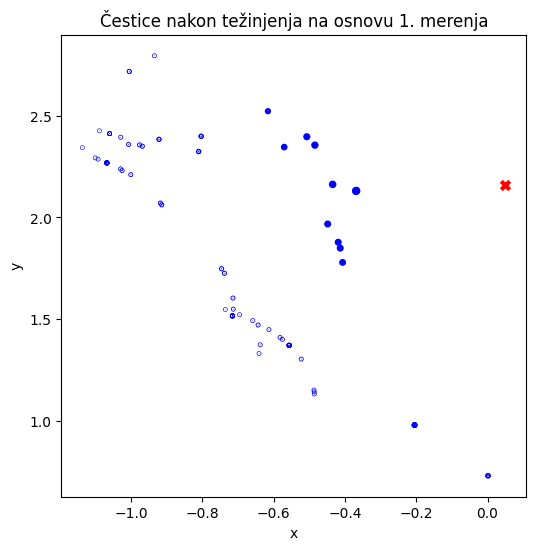

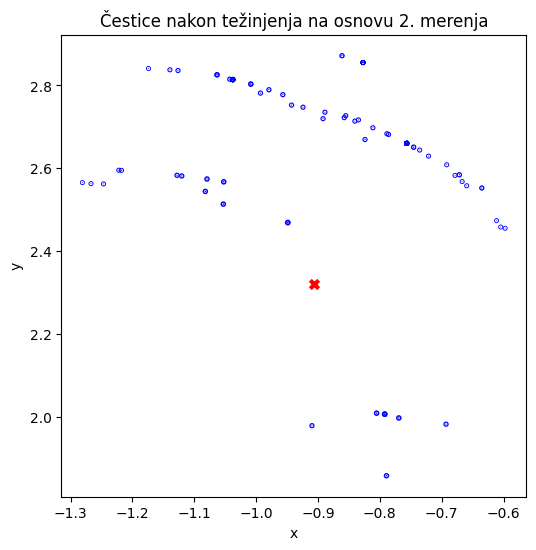

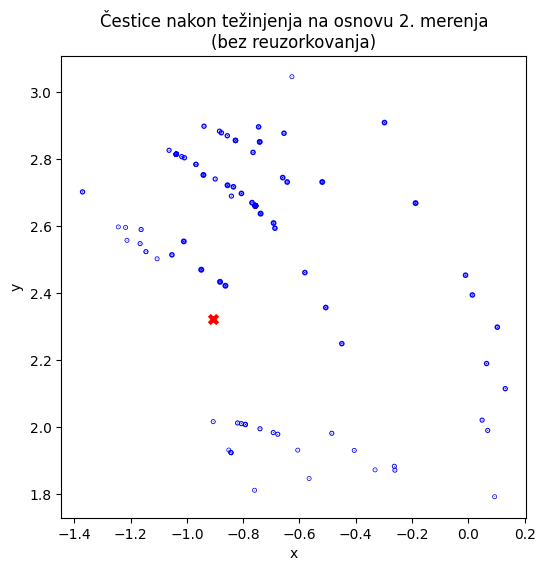

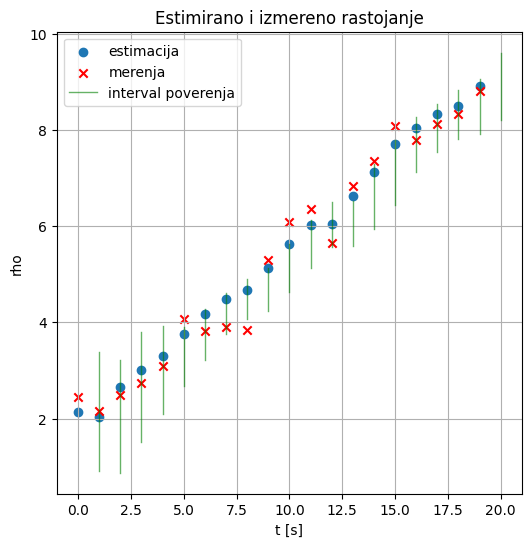

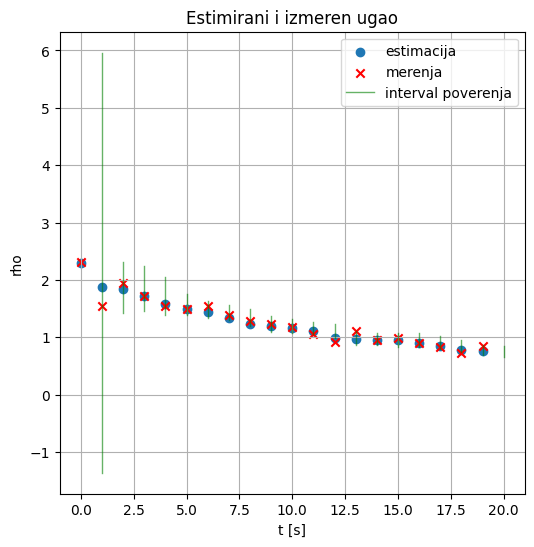

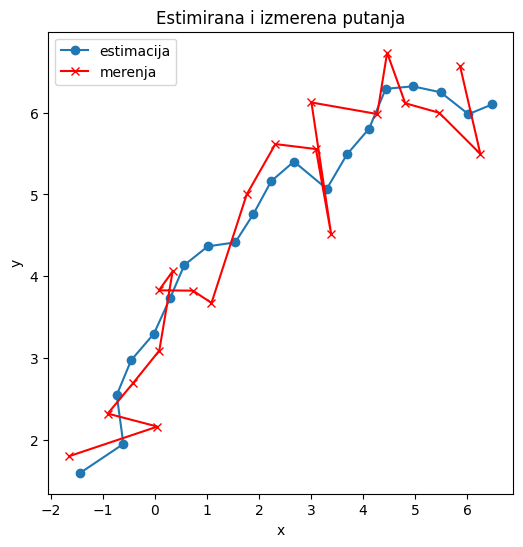

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Učitavanje opservacija

def read_data(path):

    data = np.array(pd.read_csv(path, header=None))
    rho = data[:,0]     # m
    theta = data[:,1]   # rad
    N_o = len(rho)  # broj opservacija

    return (rho, theta, N_o)

### Inicijalizacija početnih vrednosti

def initialization(N):

    x_init = np.random.uniform(low=-2, high=2, size=N)  # početna pozicija po x osi
    y_init = np.random.uniform(low=-2, high=2, size=N)  # početna pozicija po y osi
    alpha_init = np.random.uniform(low=0, high=2*np.pi, size=N) # početni pravac kretanja

    particles = np.array([x_init, y_init, alpha_init])  # 3 x N
    weights = 1/N*np.ones((N))

    return (particles, weights)

### Model kretanja

def motion_model(particles, v, T, p_turning):

    x = particles[0,:]
    y = particles[1,:]
    alpha = particles[2,:]

    # ažuriranje pravca kretanja
    for i in range(len(x)):

        if random.random() <= p_turning[i]:
            alpha[i] += np.random.uniform(low=-np.pi/6, high=np.pi/6)
            alpha[i] = np.mod(alpha[i], 2*np.pi)
            p_turning[i] = 0.2
        else:
            p_turning[i] += 0.2

        # ažuriranje pozicije
        x[i] += v*np.cos(alpha[i])*T
        y[i] += v*np.sin(alpha[i])*T

    particles[0,:] = x
    particles[1,:] = y
    particles[2,:] = alpha

    return particles

### Model merenja

def sigma_rho(theta, alpha):

    sigma_rho_t = 0.3
    sigma_rho_n = 0.6
    k = (sigma_rho_n-sigma_rho_t)/(np.pi/2)

    theta = np.mod(theta, 2*np.pi)
    alpha = np.mod(alpha, 2*np.pi)

    angle = alpha - theta
    angle = np.mod(angle, 2*np.pi)

    if (np.pi/2 <= angle) and (angle <= np.pi):
        angle = np.pi - angle
    elif (np.pi <= angle) and (angle <= 3*np.pi/2):
        angle = angle - np.pi
    elif (3*np.pi/2 <= angle) and (angle <= 2*np.pi):
        angle = 2*np.pi - angle

    sigma_rho = sigma_rho_t + k*angle

    return sigma_rho

### Ažuriranje težina na osnovu opservacija

def weights_update(particles, weights, rho, theta):

    x = particles[0,:]
    y = particles[1,:]
    alpha = particles[2,:]

    for i in range(len(x)):

        rho_tmp = np.sqrt(x[i]**2 + y[i]**2)
        theta_tmp = np.mod(np.arctan2(y[i], x[i]), 2*np.pi)

        sigma_rho_tmp = sigma_rho(theta, alpha[i])
        sigma_theta = np.pi/36

        weight_rho = np.exp(-0.5*((rho_tmp-rho)/sigma_rho_tmp)**2 / (np.sqrt(2*np.pi)*sigma_rho_tmp)) # normalna raspodela
        weight_theta = np.exp(-np.abs(theta_tmp-theta)/sigma_theta) / (2*sigma_theta)   # Laplasova raspodela
        weights[i] *= weight_rho*weight_theta

    weights /= np.sum(weights)  # normalizacija težina tako da zbir bude 1

    return weights

### Estimacija pozicije

def estimation(particles, weights):

    x = particles[0,:]
    y = particles[1,:]

    x_est = np.sum(x*weights)
    y_est = np.sum(y*weights)

    rho_est = np.sqrt(x_est**2 + y_est**2)
    rho_std = np.std(np.sqrt(x**2 + y**2))

    theta_est = np.mod(np.arctan2(y_est, x_est), 2*np.pi)
    theta_std = np.std(np.mod(np.arctan2(y, x), 2*np.pi))

    return (x_est, y_est, rho_est, theta_est, rho_std, theta_std)

### Reuzorkovanje čestica

def resampling(particles, weights):

    N = len(weights)

    indices = np.random.choice(a=range(N), p=weights, size=N, replace=True)
    particles = particles[:,indices]
    weights = 1/N*np.ones((N))

    # unošenje perturbacije kako bi se umanjilo osiromašenje uzorka
    particles[:2,:] = particles[:2,:] + np.random.normal(loc=0, scale=0.2, size=(2,N))

    return (particles, weights)

# Prikaz čestica
def plot_particles(particles, weights, iter, rho, theta, str=""):

    N_plot = 100

    sorted_weights_indices = np.argsort(weights)[::-1]
    top_indices = sorted_weights_indices[:N_plot]

    top_particles = particles[:,top_indices]
    top_weights = weights[top_indices]

    plt.figure(figsize=(6,6))
    plt.scatter(top_particles[0,:], top_particles[1,:], s=top_weights*100, linewidths=3, alpha=1, c='b')
    plt.scatter(rho*np.cos(theta), rho*np.sin(theta), marker='x', c='r', linewidths=3)
    plt.xlabel('x'); plt.ylabel('y')
    plt.title("Čestice nakon težinjenja na osnovu {}. merenja".format(iter)+str)

    return

### Čestični filtar

(rho, theta, N_o) = read_data("observations.csv")   # merenja

T = 1   # s
t = range(0, N_o*T, T)  # vremenska osa
v = 0.5 # m/s

N = 1000    # broj čestica

p_turning = 0.2*np.ones((N))
rho_est = np.zeros((N_o))
rho_std = np.zeros((N_o))
theta_est = np.zeros((N_o))
theta_std = np.zeros((N_o))
est_trajectory = np.zeros((2,N_o))

# Inicijalizacija
(particles, weights) = initialization(N)

for i in range(N_o):

    # Predikcija
    particles = motion_model(particles, v, T, p_turning)

    if i == 2:
        particles_old = motion_model(particles_old, v, T, p_turning)

    # Opservacija
    weights = weights_update(particles, weights, rho[i], theta[i])

    if i == 1:
        plot_particles(particles, weights, i, rho[i], theta[i])

    elif i == 2:

        weights_old = weights_update(particles_old, weights_old, rho[i], theta[i])
        plot_particles(particles, weights, i, rho[i], theta[i])
        plot_particles(particles_old, weights_old, i, rho[i], theta[i], "\n(bez reuzorkovanja)")

    # Estimacija
    (x_est, y_est, rho_est[i], theta_est[i], rho_std[i], theta_std[i]) = estimation(particles, weights)
    est_trajectory[:,i] = (x_est, y_est)

    # Reuzorkovanje
    if i==1:
        # za prikaz bez reuzorkovanja
        particles_old = particles
        weights_old = weights

    (particles, weights) = resampling(particles, weights)


### Prikaz estimiranog i izmerenog rastojanja 
plt.figure(figsize=(6,6))
plt.scatter(t, rho_est, marker='o')
plt.scatter(t, rho, c='r', marker='x')
for i in range(N_o):
    plt.plot([i + 1, i + 1], [rho_est[i] - 2*rho_std[i], rho_est[i] + 2*rho_std[i]], 'g', linewidth=1, alpha=0.6)
plt.legend(['estimacija','merenja','interval poverenja'])
plt.xlabel('t [s]'); plt.ylabel('rho'); plt.title('Estimirano i izmereno rastojanje')
plt.grid()
plt.show()

### Prikaz estimiranog i izmerenog ugla
plt.figure(figsize=(6,6))
plt.scatter(t, theta_est, marker='o')
plt.scatter(t, theta, c='r', marker='x')
for i in range(N_o):
    plt.plot([i + 1, i + 1], [theta_est[i] - 2*theta_std[i], theta_est[i] + 2*theta_std[i]], 'g', linewidth=1, alpha=0.6)
plt.legend(['estimacija','merenja','interval poverenja'])
plt.xlabel('t [s]'); plt.ylabel('rho'); plt.title('Estimirani i izmeren ugao')
plt.grid()
plt.show()

### Prikaz estimirane i izmerene putanje
plt.figure(figsize=(6,6))
plt.plot(est_trajectory[0,:], est_trajectory[1,:], marker='o', label='estimacija')
plt.plot(rho*np.cos(theta), rho*np.sin(theta), c='r', marker='x', label='merenja')
plt.legend()
plt.xlabel('x'); plt.ylabel('y'); plt.title('Estimirana i izmerena putanja')
plt.show()
